# Вторая лабораторная. Обработка изображений

Лабораторная состоит из гайда по базовым методам обработки изображений на Python, двух обязательных заданий и одного дополнительного (дополнительное задание может принести +2 балла):

* [Задание 1](#Задание-1.) - подбор изображения, на котором преобразование Хафа находит прямые;
* [Задание 2](#Задание-2.) - сегментация (выделение объекта на изображении) поиском границ;
* [Задание 3 (дополнительное)](#Задание-3-(дополнительное)) - перспективное преобразование.

Сначала рекомендуется ознакомиться с гайдом, после чего выполнять задания.

*В этом ноутбуке изначально опущены результаты исполнения кода. Рекомендуется запускать (Ctrl+Enter) ячейки по мере просмотра документа*

#### Используемые модули

Обновим пакетный менеджер pip, чтобы корректно уставить необходимые модули:

In [2]:
# При необходимости добавляйте опцию --user
!pip install --upgrade pip --user

Установим необходимые модули:

In [3]:
# При необходимости добавляйте опцию --user
!pip install -r requirements.txt

  Using cached scipy-1.7.3-cp39-cp39-win_amd64.whl (34.3 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.2
    Uninstalling scipy-1.6.2:
      Successfully uninstalled scipy-1.6.2


Подключим модули, которые пригодятся в мини-лабораторной.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from imageio import imread, imsave
from skimage.color import rgb2gray, label2rgb
from skimage.transform import hough_line, hough_line_peaks, warp, AffineTransform
from skimage.feature import canny, corner_harris, corner_peaks, corner_fast, corner_subpix, match_descriptors, ORB
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.segmentation import watershed
from skimage.morphology import binary_closing, binary_erosion
from skimage.measure import ransac
from scipy import ndimage as ndi
import cv2
import os
from save_answer import add_to_answer

## 1. Преобразование Хафа

Достаточно часто возникает задача распознавания геометрических объектов (прямых, окружностей и т.п.)

Найдём границы куба с помощью преобразования Хафа:

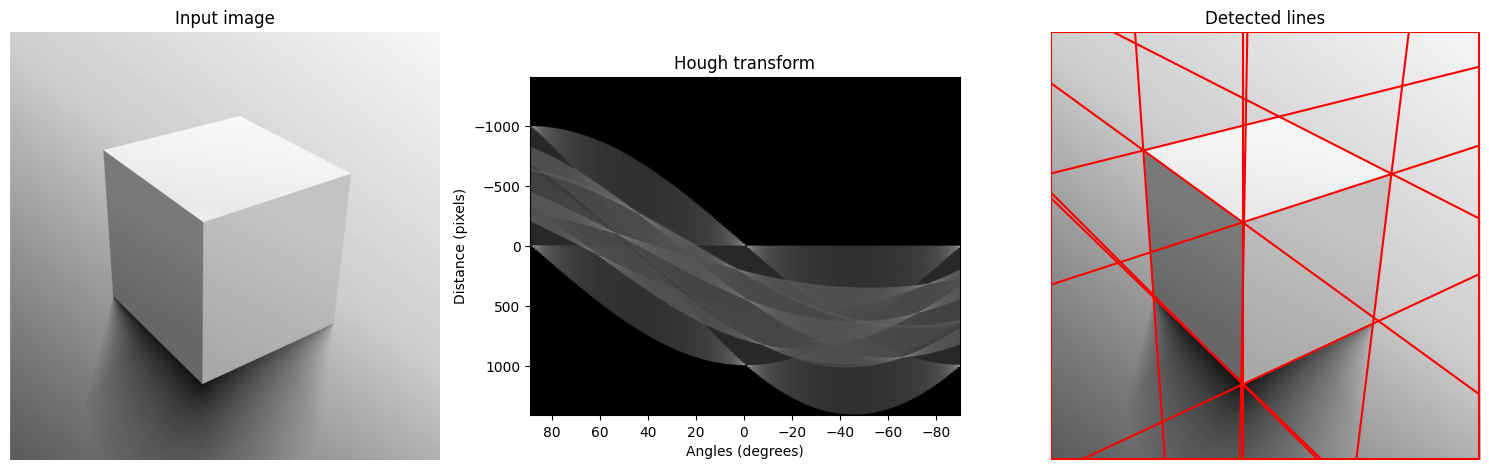

In [5]:
def show_hough_transform(image, threshold=100):
    borders = canny(image)  # вычисляем преобразование Хафа от границ изображения
    h, theta, d = hough_line(borders)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Input image')
    ax[0].set_axis_off()

    ax[1].imshow(np.log(1 + h),
                 extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
                 cmap='gray', aspect=1/20)
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')

    ax[2].imshow(image, cmap='gray')
    # hough_line_peaks возвращает кортеж из трёх списков.
    # Чтобы удобно было итерироваться в цикле, мы разворачиваем списки
    # с помощью звёздочки, потом снова заворачиваем с помощью zip,
    # чтобы итерироваться по списку кортежей-троек.
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d, threshold=threshold)):
        # Переводим полярные координаты в декартовы, чтобы отрисовать
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        # Рисуем линию по точке и направлению
        ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2), c='r', ls='-')
    ax[2].set_xlim((0, image.shape[1]))
    ax[2].set_ylim((image.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    plt.tight_layout()

cube = rgb2gray(imread(os.path.join("images", "cube.jpg")))
show_hough_transform(cube, threshold=100)

---

### Задание 1.

Подберите изображение, на котором с помощью преобразования Хафа можно найти несколько прямых (не менее четырёх):

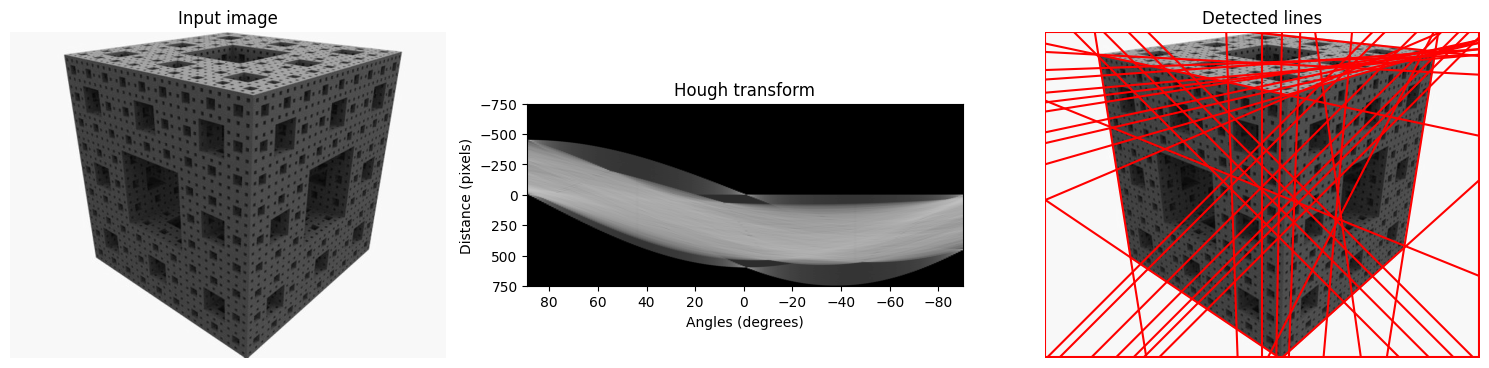

In [18]:
image_file = os.path.join("images", "menger.jpg")

image_as_gray = rgb2gray(imread(image_file))

# Параметр threshold можно менять
threshold = 110
show_hough_transform(image_as_gray, threshold=threshold)
result_image = os.path.join("images", "task_1.png")
plt.savefig(result_image, dpi=150)

# Сохранение результатов
add_to_answer(
    "task_1",
    {
        "source_image": image_file,
        "result_image": result_image,
        "threshold": threshold,
    },
)

---

## Поиск границ

Часто возникает задача поиска границ на изображении: они могут быть использованы для распознавания образов (Object Detection), сегментации и классификации изображений. Так, в предыдущей задаче поиск линий осуществлялся именно на карте границ, а не на исходном изображении.

Посмотрим на различные фильтры, помогающие при выделении границ:

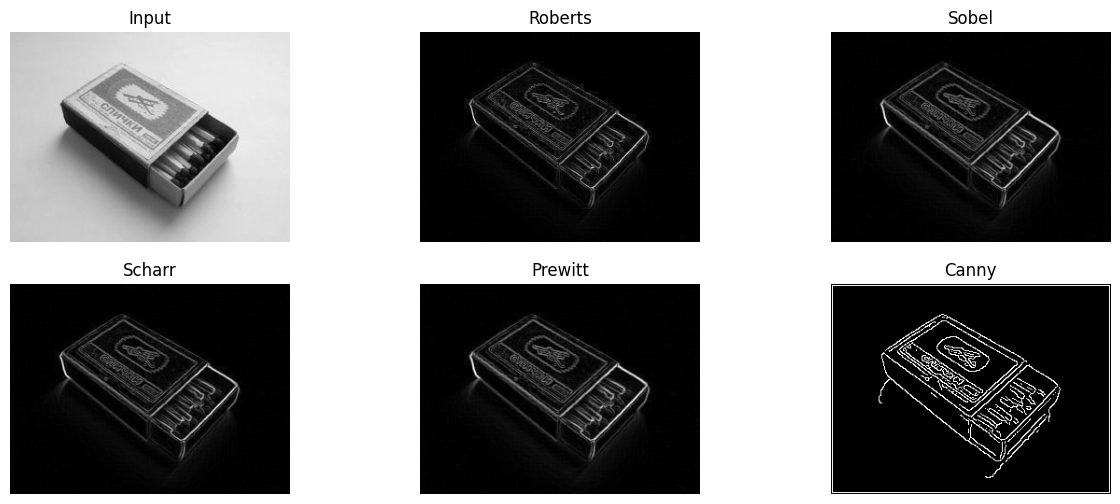

In [19]:
# детекторы границ по умолчанию работают с одним каналом, поэтому используем rgb2gray
matchbox = rgb2gray(imread(os.path.join("images", "matchbox.jpg")))

fig, ax = plt.subplots(2, 3, figsize=(15, 6))
ax[0, 0].imshow(matchbox, cmap='gray')
ax[0, 1].imshow(roberts(matchbox), cmap='gray')
ax[0, 2].imshow(sobel(matchbox), cmap='gray')
ax[1, 0].imshow(scharr(matchbox), cmap='gray')
ax[1, 1].imshow(prewitt(matchbox), cmap='gray')
ax[1, 2].imshow(canny(matchbox), cmap='gray')
for i, title in enumerate(["Input", "Roberts", "Sobel", "Scharr", "Prewitt", "Canny"]): ax.flatten()[i].set_title(title)
for i in range(6): ax.flatten()[i].set_axis_off()

Фильтры Roberts, Sobel, Scharr, Prewitt вычисляют различные аппроксимации модуля градиента.

Детектор Canny - находит тонкие границы, соответствующие локальным максимумам модуля градиента. Поэтому зачастую граница состоит из набора коротких кривых. И для edge-based сегментации (выделения полного контура объекта) с помощью детектора Canny требуется подбирать параметры.

Выделим спичечный коробок на изображении двумя способами: с помощью карты границ, полученной детектором Canny, и с помощью так называемой region-based сегментации - методом [водораздела](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29), применяя аппроксимацию модуля градиента Собеля.

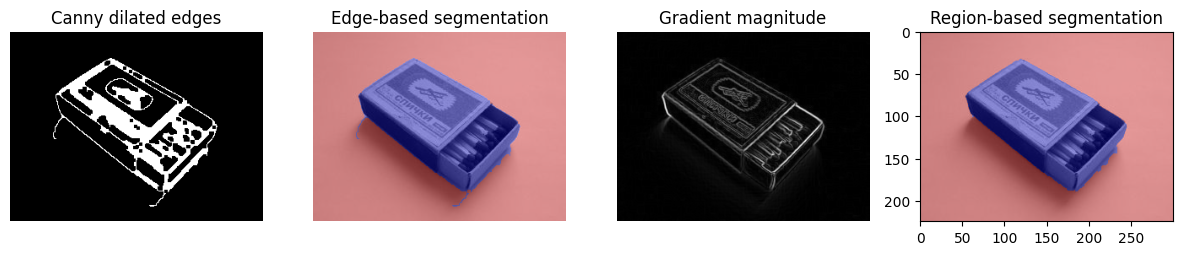

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(15, 6))

# Применяем фильтр canny, чтобы выделить кривые. Поверх маски с результатом
# применяем морфологическое закрытие, чтобы немного продлить границы.
# Продление границ нужно, чтобы основные контуры, очерчивающие объект, замкнулись
canny_edge_map = binary_closing(canny(matchbox, sigma=1), footprint=np.ones((4, 4)))

# По краям изображения фильтр canny тоже находит границы, для корректной работы
# binary_fill_holes ("закрашивание дыр") эти границы следует убрать
def correct_mask_borders_after_canny(canny_result, border_width=3):
    # заполняем полосы толщиной border_width нулями
    canny_result[:border_width,:] = 0
    canny_result[:,:border_width] = 0
    canny_result[-border_width:,:] = 0
    canny_result[:,-border_width:] = 0

correct_mask_borders_after_canny(canny_edge_map)
# Заполняем "дыры", чтобы маска соответствовала объекту
matchbox_edge_segmentation = ndi.binary_fill_holes(canny_edge_map)

ax[0].imshow(canny_edge_map, cmap='gray')
ax[1].imshow(label2rgb(matchbox_edge_segmentation.astype(int), image=matchbox, bg_label=2))

# поставим маркеры фона и объекта
markers = np.zeros_like(matchbox)  # создаём матрицу markers того же размера и типа, как matchbox
markers[0:10, 0:10] = 1 # ставим маркеры фона
markers[binary_erosion(canny_edge_map) > 0] = 2 # ставим маркеры объекта - точки, находящиеся заведомо внутри

sobel_gradient = sobel(matchbox)
matchbox_region_segmentation = watershed(sobel_gradient, markers)

ax[2].imshow(sobel_gradient, cmap='gray')
ax[3].imshow(label2rgb(matchbox_region_segmentation, image=matchbox, bg_label=0))

for i, title in enumerate(["Canny dilated edges", "Edge-based segmentation", "Gradient magnitude", "Region-based segmentation"]): ax[i].set_title(title)
for i in range(3): ax[i].set_axis_off()

Визуально оба метода справились достаточно хорошо, но у каждого есть свои недостатки и преимущества:
* edge-based сегментация в данном случае дала не совсем корректный результат (в маску вошли две лишние кривые, идущие по тени), при этом вручную были подобраны параметры фильтра и ядра дилатации;
* для region-based пришлось вручную задать маркеры объекта - на практике такой информации могло бы и не быть.

---

### Задание 2.

* Подберите изображение, на котором можно выделить объект первым подходом (с помощью карты границ). При этом на изображении должен быть **неоднородный** фон;
* Подберите параметры детектора границ и морфологических операций, чтобы получить максимально точную маску.

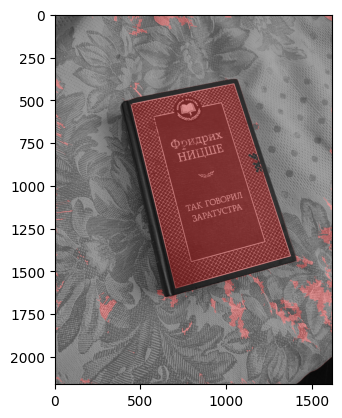

In [29]:
segment_image_file = os.path.join("images", "book.jpg")
easy_to_segment = rgb2gray(imread(segment_image_file))

# Эти параметры можно менять
canny_sigma = 1
canny_low_threshold = 0.04
canny_high_threshold = 1
binary_closing_footprint_width = 4
binary_closing_footprint = np.ones((binary_closing_footprint_width, binary_closing_footprint_width))

my_edge_map = binary_closing(
    canny(
        easy_to_segment,
        sigma=canny_sigma,
        low_threshold=canny_low_threshold,
        high_threshold=canny_high_threshold,
    ),
    footprint=binary_closing_footprint
)
correct_mask_borders_after_canny(my_edge_map)
my_edge_segmentation = ndi.binary_fill_holes(my_edge_map)

plt.imshow(label2rgb(my_edge_segmentation, image=easy_to_segment))
result_image_file = os.path.join("images", "task_2.png")
plt.savefig(result_image_file, dpi=150)

# Сохранение результатов
add_to_answer(
    "task_2",
    {
        "source_image": segment_image_file,
        "result_image": result_image_file,
        "params": {
            "canny": {
                "sigma": canny_sigma,
                "low_threshold": canny_low_threshold,
                "high_threshold": canny_high_threshold,
            },
            "binary_closing_footprint_width": binary_closing_footprint_width,
        },
    },
)

---


## Особые точки 

Особые точки - один из основных механизмов извлечения признаков для распознавания образов и локализации заданного объекта на изображении.

Существует несколько типов особых точек и дескрипторов:
* инвариантные к сдвигу, масштабированию и повороту - SIFT, SURF, FAST;
* инвариантные к масштабированию, но не к повороту - U-SURF;
* не инвариантные к масштабированию - Blob (обычно дескрипторы описывают соответствующие точки, но с разным значением радиуса);
* и другие.

Посмотрим на результаты работы различных детекторов:

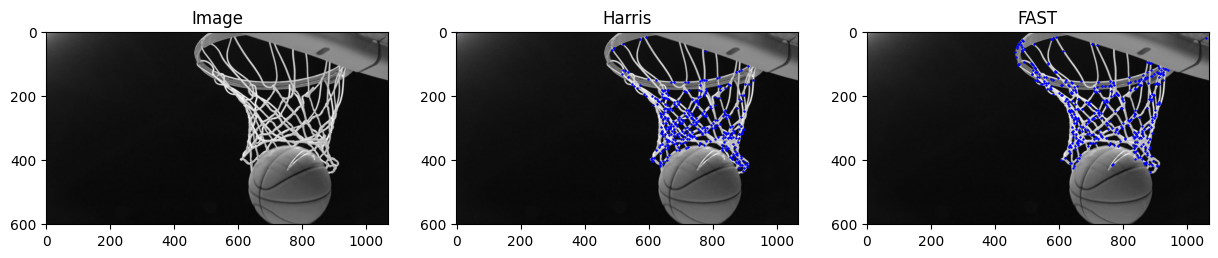

In [30]:
basketball = rgb2gray(imread(os.path.join("images", "basketball.jpg")))

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].set_title('Image')
ax[0].imshow(basketball, cmap='gray')

# corner_harris возвращает матрицу, в которой максимумы соответствуют особым точкам
# поэтому чтобы извлечь координаты надо вызвать corner_peaks
basketball_harris = corner_peaks(corner_harris(basketball), threshold_rel=0.1)
ax[1].set_title('Harris')
ax[1].imshow(basketball, cmap='gray')
ax[1].plot(basketball_harris[:, 1], basketball_harris[:, 0], '+b', markersize=2)

basketball_fast = corner_peaks(corner_fast(basketball), threshold_rel=0.1)
ax[2].set_title('FAST')
ax[2].imshow(basketball, cmap='gray')
ax[2].plot(basketball_fast[:, 1], basketball_fast[:, 0], '+b', markersize=2)

Решим задачу стабилизации видеоряда: дана последовательность изображений (для простоты - два), требуется сделать так, чтобы объект занимал одно и то же положение в кадре.

Сначала сгенирируем данные искусственным образом: пусть камера немного повернулась против часовой стрелки и сдвинулась вверх.
Получим новую картинку поворотом старой на 3 градуса и сдвигом на 20 пикселей вправо и вниз, и посмотрим на особые точки:

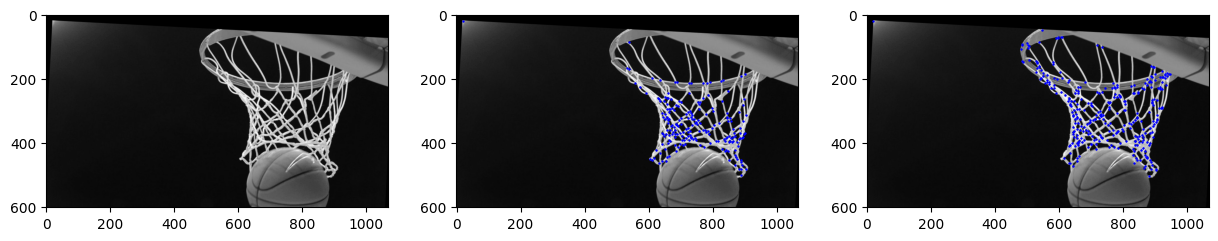

In [31]:
tform = AffineTransform(rotation=np.deg2rad(3), translation=(20, 20))
basketball2 = warp(basketball, tform.inverse, output_shape=basketball.shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(basketball2, cmap='gray')

basketball2_harris = corner_peaks(corner_harris(basketball2), threshold_rel=0.1)
ax[1].imshow(basketball2, cmap='gray')
ax[1].plot(basketball2_harris[:, 1], basketball2_harris[:, 0], '+b', markersize=2)

basketball2_fast = corner_peaks(corner_fast(basketball2), threshold_rel=0.1)
ax[2].imshow(basketball2, cmap='gray')
ax[2].plot(basketball2_fast[:, 1], basketball2_fast[:, 0], '+b', markersize=2)

Видно, что часть особых точек находится в тех же местах объекта, где и была до поворота.

Найдём дескрипторы особых точек исходной и искажённой картинок, и сдвинем вторую картинку, чтобы она занимала исходное положение.

Для этого воспользуемся *ORB* - детектором (*Oriented FAST and rotated BRIEF*) и методом RANSAC для поиска аффинного преобразования, после чего применим обратное аффинное преобразование:

Оценка сдвига: [19.86942396 20.14332054]
Оценка поворота: -2.9986161682797223


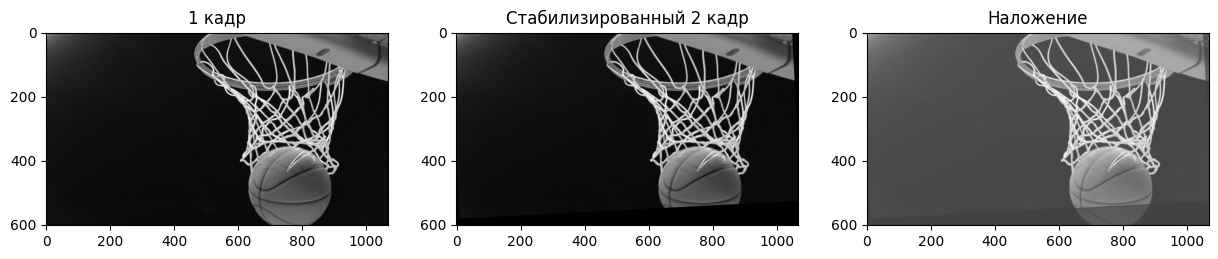

In [32]:
orb = ORB()
orb.detect_and_extract(basketball)

orb2 = ORB()
orb2.detect_and_extract(basketball2)

basketball_match = match_descriptors(orb.descriptors, orb2.descriptors, cross_check=True)

src = orb.keypoints[basketball_match[:, 0]]
dst = orb2.keypoints[basketball_match[:, 1]]
    
estimated_transform, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=1000)

basketball3_stab = warp(basketball2, AffineTransform(translation=estimated_transform.translation,
                                                     rotation=-estimated_transform.rotation),
                        output_shape=basketball2.shape)


fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(basketball, cmap='gray')
ax[1].imshow(basketball3_stab, cmap='gray')
ax[2].imshow(basketball, cmap='gray', alpha=0.5)
ax[2].imshow(basketball3_stab, cmap='gray', alpha=0.5)

for i, title in enumerate(['1 кадр', 'Стабилизированный 2 кадр', 'Наложение']): ax[i].set_title(title)

print(f"Оценка сдвига: {estimated_transform.translation}")
print(f"Оценка поворота: {np.rad2deg(estimated_transform.rotation)}")

Видно, что подход работает достаточно хорошо, поэтому его часто применяют для решения аналогичных задач на практике. Существуют и другие подходы к решению данной задачи: оценка оптического потока (Optical Flow), и сопоставление с шаблоном с помощью преобразования Фурье.

Точно такую же технику можно использовать для решения задачи поиска гомографии, в частности - проективного преобразования, то есть для поиска отображения, преобразующего шаблонное изображение (например, qr-код) в объект на другом заданном изображении (снимке с камеры). С помощью найденной (или не найденной) гомографии можно установить есть ли объект на изображении, где он находится; исправить перспективу; отрендерить 3d-объект, чтобы он реалистично вписывался в сцену (AR), и другое.

---

### Задание 3 (дополнительное)
*Задание выполнять не обязательно, но оно позволяет получить 2 дополнительных балла за лабораторную.*

* Подберите два изображения, таких, что объект из первого изображения присутствует на втором изображении (можно сделать две фотографии: объекта отдельно и объекта в окружении), см. пример внизу;
* Найдите гомографию, используя метод `cv2.findHomography` и один из способов поиска особых точек;
* Задайте на первом изображении четырёхугольник, ограничивающий объект;
* Обведите четырёхугольником найденный объект на втором изображении, используя `cv2.warpPerspective` или `cv2.perspectiveTransform`;
* Сохрание в файл `task_3_result.png` результат - картинку, на которой слева первое изображение с четырёхугольником, ограничивающим объект (этот четырёхугольник задавался вручную), справа - второе изображение с четырёхугольников, ограничивающим объект (этот четырёхугольник был получен перспективным преобразованием).

_Пояснение:_ четырёхугольник, ограничивающий объект, вручную задаётся для первого изображения. С помощью перспективного преобразования (которое найдено по сопоставлению особых точек) этот четырёхугольник переносится на второе изображение, где его образ тоже является четырёхугольником, ограничивающим объект. При этом на **втором** изображении **не нужно** задавать ограничивающий многоугольник вручную: он должен получиться автоматически в результате применения перспективного преобразования.

![Homography](https://www.learnopencv.com/wp-content/uploads/2016/01/homography-example.jpg)

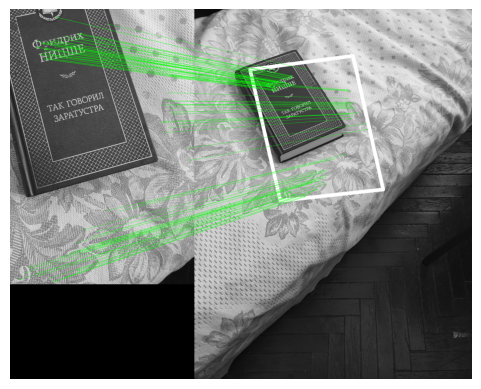

In [40]:
source_image_file_first = os.path.join("images", "book.jpg")
source_image_file_second = os.path.join("images", "book3.jpg")
result_image_file = os.path.join("images", "task_3_result.png")


# Напишите здесь код для решения задания


# Сохраните картинку с двумя "подграфиками":
#  - на первом: первую картинку с нарисованным поверх ограничивающим 4-угольником, заданным вручную
#  - на втором: вторую картинку с нарисованным поверх вычисленным ограничивающим 4-угольником

MIN_MATCH_COUNT = 10


img = cv2.imread(source_image_file_first, 0)  # queryImage
img2 = cv2.imread(source_image_file_second, 0)  # trainImage


# cv.imshow("cropped", cropped_image)

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test.
good = []

for m, n in matches:
    if m.distance < 0.5*n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    h, w = img1.shape
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 20, cv2.LINE_AA)
else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None

draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   matchesMask=matchesMask,  # draw only inliers
                   flags=2)

img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
plt.axis('off')
plt.imshow(img3, 'gray')
# plt.show()
plt.savefig(result_image_file, dpi=150)
# Сохранение результатов
add_to_answer(
    "task_3",
    {
        "source_image_file_first": source_image_file_first,
        "source_image_file_second": source_image_file_second,
        "result_image": result_image_file,
    },
)